# Tutorial for `dukes`

In this tutorial, I'll briefly go through main classes and functions that are used to evaluate the signatures of diffuse boosted dark matter (BDM) yielded by the supernova neutrinos in the high-redshit galaxies from the early Universe.


We begin with importing `dukes` and other useful packages in this tutorial. Note that `multiprocessing` is not compatible with jupyter on Mac/Windows systems.
One can alternatively use `ipyparallel` to manifest multiprocessing feature on jupyter. This task is relegated to the user.

In [1]:
# import complete modules from packages
import multiprocessing as mp
import numpy as np
import dukes
import matplotlib.pyplot as plt

# import only necessary modules from packages
from functools import partial
from scipy.integrate import quad

# uncomment this if you have a Hi-DPI monitor and wish to have a better figure resolution
#%matplotlib inline
#%config InlineBackend.figure_format='retina'

## Useful constants

We introduce the fundamental class `constant` that is frequently inhereited by other classes in `dukes`. This class contains various physical constants and conversion factors that are commonly used in this package.
For example the physical quantities such as electron mass $m_e$, proton mass $m_p$, neutron mass $m_n$ and the Solar mass $M_\odot$ are expressed in MeV

In [70]:
dukes.constant.me, dukes.constant.mp, dukes.constant.mn, dukes.constant.Msun

(0.511, 938.2, 939.5, 1.115e+60)

Conversion factors like erg to MeV, year to seconds and kiloparsec to centimeters

In [13]:
dukes.constant.erg2MeV, dukes.constant.year2Seconds, dukes.constant.kpc2cm

(624100.0, 31560000.0, 3.085e+21)

Other constants can be checked form the docstring of the class.

## Baryonic density distribution of galaxy

We implement the baryonic density profile $\rho_b(R,z)$ shown in McMillan, *MNRAS* **465**, 76 (2017) for Milky Way (MW) at given $(R,z)$ in cylindrical coordinate, where $R$ is the radius to the galactic center (GC) and $z$ the height. It is obtained from `dukes.mwDensityProfile(R,z)` as `(R,z)` are in kpc and the output is $M_\odot\,{\rm kpc^{-3}}$.

In [5]:
dukes.mwDensityProfile(1,0.1)

1272762188.4977636

Since the height $z$ is much smaller than the radius $R$, we can further evaluate the area density by integrating out $z$ for later convenience
$$
\Sigma_b(R)= 2\int_{0}^{z_{\rm max}} dz ~\rho_b(R,z).
$$
The factor 2 is a natural consequence of symmetric $\rho_b$ under $z\to-z$, and $z_{\rm max}$ is the truncation point. In principle $\rho_b(R,z)$ varies little when $z$ is larger than a few kpc. We can safely set $z_{\rm max}=10$ kpc.

In [23]:
def Sigma_b(R,zmax=10):
    return quad(lambda z: dukes.mwDensityProfile(R,z),-zmax,zmax)[0]
# initializing mp
pool = mp.Pool(8)
RList = np.logspace(-3,2,30)
Sigma_b_data = pool.map(Sigma_b,RList)

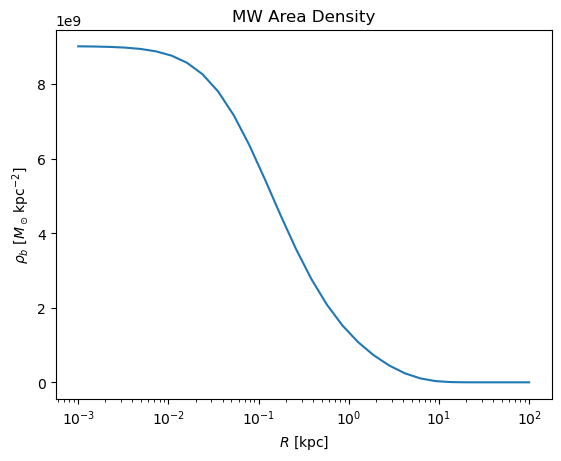

In [25]:
plt.plot(RList,Sigma_b_data)
plt.xscale('log')
plt.title('MW Area Density')
plt.xlabel(r'$R$ [kpc]')
plt.ylabel(r'$\rho_b~[M_\odot\,{\rm kpc^{-2}}]$')
plt.show()

### $\rho_b$ with arbitrary $M_G$

For galaxies with arbitrary stellar mass $M_G$, we assume the baryonic profile still follows MW but the corresponding characteristic quantities are scaled with $M_G$. For characteristic radius, we assume it is proportional to $M_G^{1/3}$ and for density is proportional to $M_G$. All these quantities will degenerate to MW's when $M_G=M_{\rm MW}$ where $M_{\rm MW}$ is the MW stellar mass.

The corresponding function is `dukes.galacticDensityProfile(R,z,MG)` where `(R,z,MG)` are in (kpc, kpc, $M_\odot$) and the output is $M_\odot\,{\rm kpc}^{-3}$.

In [7]:
dukes.galacticDensityProfile(5.9,0.1,1e10)

8471024.103398217

We can compare with `dukes.mwDensityProfile`

In [8]:
RList = np.logspace(-3,2,50)
rhob_MW_exact_z0 = []
rhob_MW_scaled_z0 = []
rhob_MW_exact_z01 = []
rhob_MW_scaled_z01 = []
rhob_MW_exact_z5 = []
rhob_MW_scaled_z5 = []
for R in RList:
    rhob_MW_exact_z0.append(dukes.mwDensityProfile(R,0))
    rhob_MW_scaled_z0.append(dukes.galacticDensityProfile(R,0,MG=dukes.constant.Mmw))
    rhob_MW_exact_z01.append(dukes.mwDensityProfile(R,0.1))
    rhob_MW_scaled_z01.append(dukes.galacticDensityProfile(R,0.1,MG=dukes.constant.Mmw))
    rhob_MW_exact_z5.append(dukes.mwDensityProfile(R,5))
    rhob_MW_scaled_z5.append(dukes.galacticDensityProfile(R,5,MG=dukes.constant.Mmw))

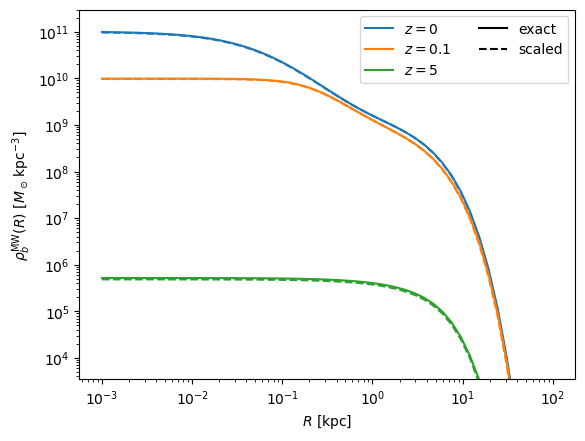

In [44]:
plt.plot(RList,rhob_MW_exact_z0,color='C0',label=r'$z=0$')
plt.plot(RList,rhob_MW_scaled_z0,'--',color='C0')
plt.plot(RList,rhob_MW_exact_z01,color='C1',label=r'$z=0.1$')
plt.plot(RList,rhob_MW_scaled_z01,'--',color='C1')
plt.plot(RList,rhob_MW_exact_z5,color='C2',label=r'$z=5$')
plt.plot(RList,rhob_MW_scaled_z5,'--',color='C2')
# for legend plot
plt.plot([1,10],[-1,-1],'k',label='exact')
plt.plot([1,10],[-1,-1],'k--',label='scaled')

plt.xscale('log')
plt.yscale('log')
plt.ylim(3500,3e11)
plt.legend(ncols=2)
plt.xlabel(r'$R$ [kpc]')
plt.ylabel(r'$\rho_b^{\rm MW}(R)~[M_\odot\,{\rm kpc}^{-3}]$ ')
plt.show()

The area density for arbitrary $M_G$ can be evaluated by `dukes.galacticAreaDensity(R,zRange=[-10,10],MG=None)` where `R` is in kpc, `zRange` the integration for height $z$ and `MG` the galactic mass. The output is $M_\odot\,{\rm kpc}^{-2}$. If `MG` is `None` then it automatically calls `dukes.mwDensityProfile`, and `dukes.galacticDensityProfile` otherwise.

In [58]:
R,zRange,MG = 5,[-2,18],5.7e9
dukes.galacticAreaDensity(R,zRange,MG)

3164531.512063145

## Dark matter halo profile

We assume that all dark matter (DM) halos enclose galaxies obeying Navarro-Frenk-White (NFW) profile
$$
\rho^{\rm NFW}_\chi(r) = \frac{\rho_s}{\frac{r}{r_s}(1+\frac{r}{r_s})^2}
$$
where $\rho_s$ and $r_s$ are the characteristic density and radius. This profile is spherical symmetric and $r$ is the radial quantity in spherical coordinate that centers GC.
We have a function named `dukes.rhox(r,rhos,rs)` with `(r,rhos,rs)` are in (kpc, MeV cm<sup>−3</sup>, kpc) to evaluate $\rho_\chi^{\rm NFW}$ with output is MeV cm<sup>−3</sup>.

It can be converted to number density $n_\chi$ by dividing the DM mass $m_\chi$,
$$
n_\chi^{\rm NFW}(r)=\frac{\rho^{\rm NFW}_\chi(r)}{m_\chi}.
$$
### $n_\chi^{\rm NFW}$ with arbitrary $M_G$
Bearing the scaling relation for arbitrary $M_G$ in baryonic density distribution, we assume this applies to DM halo shape as well.
We can up or down -scale the halo profile in terms of MW's $(\rho_s^{\rm MW},r_s^{\rm MW})=(184\,{\rm MeV\,cm^{-2}},24.42\,{\rm kpc})$ and $M_G$.
The corresponding fucntion for evaluating DM number density is `dukes.nxNFW(r,mx,rhosMW=184,rs=24.42,MG=None)`, where `mx` is the DM mass in MeV and one can see that the default values `rhosMW` $=\rho_s^{\rm MW}$ and `rsMW` $=r_s^{\rm MW}$.
When `MG` is `None`, it automatically calls the exact MW NFW profile. We can compare

In [3]:
mx = 1e-3
rList = np.logspace(-3,2,50)
mwNFW_exact = []
mwNFW_scaled = []
for r in rList:
    mwNFW_exact.append(dukes.nxNFW(r,mx))
    mwNFW_scaled.append(dukes.nxNFW(r,mx,MG=dukes.constant.Mmw))

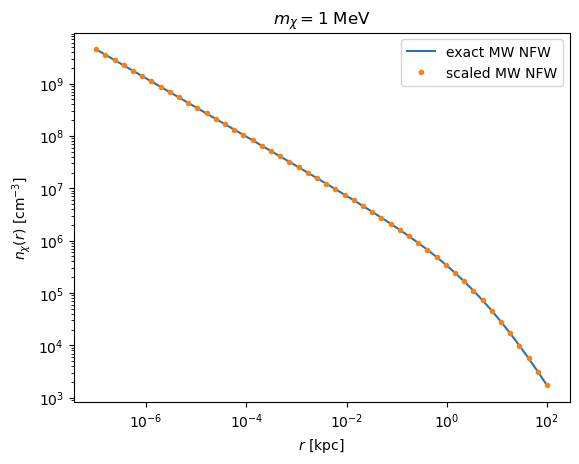

In [62]:
plt.plot(rList,mwNFW_exact,label='exact MW NFW')
plt.plot(rList,mwNFW_scaled,'.',label='scaled MW NFW')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title(r'$m_\chi = 1$ MeV')
plt.xlabel(r'$r$ [kpc]')
plt.ylabel(r'$n_\chi(r)~[{\rm cm}^{-3}]$')
plt.show()

### Including DM spike

DM can form a spiky structure in the central region of the halo due to the accretion of supermassive black hole (SMBH) and was originally proposed in Gondolo *et al., Rhys. Rev. Lett.* **83** 1719 (1999). In this package, we adopt the parameterization documented in Cline *et al., JCAP* **06**, 004 (2023) with index $\alpha = 3/2$. Other index $\alpha = 7/2$ leads to more spiky shape in the central region and is not implemented.

The function `dukes.dmNumberDensity(r,mx,MG,is_spike=True,sigv=None)` evaluates the DM number density with arbitrary $M_G$ and spike effect included (can be turn on/off). The arguments `is_spike` is a boolean and initially set `True` to include the spike effect. If it is set `False` then `dukes.nxNFW` will be called. `sigv` dicates the DM annihilation cross section $\langle \sigma v\rangle$ in the unit of 10<sup>−26</sup> cm<sup>3</sup> s<sup>−1</sup>. For example, if `sigv=3` it implies $\langle \sigma v\rangle=3\times 10^{-26}~{\rm cm^3~s^{-1}}$. If you wish to turn off DM annihilation, you have to set `sigv=None` instead of `sigv=0`. The later would yield `ZeroDivisionError` in python. Note that `sigv` only works when `is_spike=True`, otherwise, it has no effect.

We evaluate MW DM density (MeV cm<sup>−3</sup>) with spike under different $\langle \sigma v\rangle$ as an example

In [73]:
mx = 1
Mmw = dukes.constant.Mmw
rList = np.logspace(-7,2,50)
rhoxNFW_sigv0 = []
rhoxNFW_sigv3 = []
rhoxNFW_nospike = []
for r in rList:
    rhoxNFW_sigv0.append(dukes.dmNumberDensity(r,mx,MG=Mmw,is_spike=True,sigv=None)*mx)
    rhoxNFW_sigv3.append(dukes.dmNumberDensity(r,mx,MG=Mmw,is_spike=True,sigv=3)*mx)
    rhoxNFW_nospike.append(dukes.dmNumberDensity(r,mx,MG=Mmw,is_spike=False)*mx)  # sigv has no effect whatever value you set

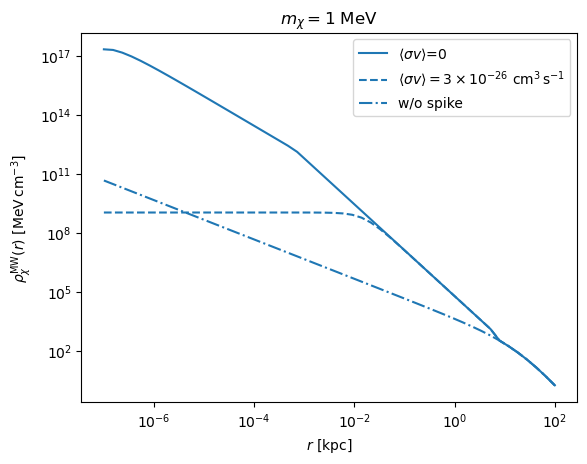

In [78]:
plt.plot(rList,rhoxNFW_sigv0,color='C0',label=r'$\langle \sigma v\rangle$=0')
plt.plot(rList,rhoxNFW_sigv3,'--',color='C0',label=r'$\langle \sigma v\rangle=3\times 10^{-26}~{\rm cm^3\,s^{-1}}$')
plt.plot(rList,rhoxNFW_nospike,'-.',color='C0',label='w/o spike')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title(r'$m_\chi = 1$ MeV')
plt.xlabel(r'$r$ [kpc]')
plt.ylabel(r'$\rho_\chi^{\rm MW}(r)~[{\rm MeV\,cm}^{-3}]$')
plt.show()

## DBDM flux and event evaluations

## Miscellaneous functions

## *Experimental* :: Implementation of model-dependent differential cross section

In [ ]:
from dukes.utils import userPhenoModelInterface

In [2]:
file = np.load('src/bin/densityParamFit.npz')

In [12]:
file2 = np.load('src/bin/galcticAreaDensityFit.npz')

In [21]:
np.savetxt('galcticAreaDensityFit.txt',file2['R'],fmt='%.3f',delimiter=",")

In [41]:
with open("galcticAreaDensityFit.txt", "w") as f:
    f.write('_R_data = [')
    for s in file2['R'].tolist():
        f.write('{:.5e}'.format(s) +", ")
    f.write('] \n\n')
    
    f.write('_MG_area_data = [')
    for s in file2['MG'].tolist():
        f.write('{:.5e}'.format(s) +", ")
    f.write('] \n\n')
    
    f.write('_rho_data = [')
    for line in file2['AreaDensity']:
        f.write('[')
        i = 0
        for s in line.tolist():
            if i != 120:
                f.write('{:.5e}'.format(s) +", ")
            else:
                f.write('{:.5e}'.format(s))
            i+=1
        f.write('],\n')
    f.write('] \n\n')

In [40]:
len(file2['AreaDensity'][0])

121

In [4]:
doom.dbdmFlux(5,1,neval=20000)

4.200418880077646e-08

In [5]:
doom.dbdmFlux(5,1,neval=50000)

4.422705310516041e-08

In [7]:
file['Sigma0Thin']

array([ 8.95223   ,  8.95223595,  8.95223594,  8.95223606,  8.95223595,
        8.95223595,  8.95223589,  8.95223593,  8.95223593,  8.95223595,
        8.95223594,  8.95223595,  8.95223596,  8.95225806,  8.95392236,
        8.9737703 ,  9.06911746,  9.31833401,  9.73665309, 10.28418383,
       10.9154326 , 11.59714772])

In [10]:
densityParamData = {
    'MG':[4.5,5.0,5.5,6.0,6.5,
          7.0,7.5,8.0,8.5,9.0,
          9.5,10.0,10.5,11.0,11.5,
          12.0,12.5,13.,13.5,14.0,
          14.5,15.0],
    'rho_b0':[8.822,8.922,9.046,9.190,9.358,
              9.548,9.758,9.985,10.228,10.4848,
              10.749,11.023,11.3035,11.588,11.877,
              12.170,12.469,12.785,13.128,13.496,
              13.890,14.317],
    'Sigma0Thick':[8.262,8.262,8.262,8.262,8.262,
                   8.262,8.262,8.262,8.262,8.262,
                   8.262,8.263,8.280,8.340,8.465,
                   8.694,9.070,9.582,10.189,10.856,
                   11.559,12.282],
    'Sigma0Thin':[8.952,8.952,8.952,8.952,8.952,
                  8.952,8.952,8.952,8.952,8.952,
                  8.952,8.952,8.952,8.952,8.953,
                  8.973,9.069,9.318,9.736,10.284,
                  10.915,11.597],
}

In [11]:
densityParamData['MG']

[4.5,
 5.0,
 5.5,
 6.0,
 6.5,
 7.0,
 7.5,
 8.0,
 8.5,
 9.0,
 9.5,
 10.0,
 10.5,
 11.0,
 11.5,
 12.0,
 12.5,
 13.0,
 13.5,
 14.0,
 14.5,
 15.0]

In [42]:
import dbdm

In [45]:
dbdm.galacticAreaDensity(0.9,MG=1e11)

1934198492.13079

In [51]:
dbdm.galacticAreaDensity(180,MG=1e8)/dbdm.galacticAreaDensityFit((180,8))

0.9944093709074541